In [149]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pathlib
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

import kagglehub

In [124]:
# Download latest version
original_path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'cards-image-datasetclassification' dataset.
Path to dataset files: /kaggle/input/cards-image-datasetclassification/test


In [125]:

path = original_path + '/train'
data_dir = path
data_dir = pathlib.Path(data_dir).with_suffix('')
data_dir

PosixPath('/kaggle/input/cards-image-datasetclassification/train')

In [126]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

7624


In [127]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       seed = 42,
                                                       image_size=(124, 124),
                                                       batch_size = 32)

Found 7624 files belonging to 53 classes.


In [128]:
path = original_path + '/valid'
data_dir = path
data_dir = pathlib.Path(data_dir).with_suffix('')


In [129]:
valid_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       seed = 42,
                                                       image_size=(124, 124),
                                                       batch_size = 32)

Found 265 files belonging to 53 classes.


In [130]:
path = original_path + '/test'
data_dir = path
data_dir = pathlib.Path(data_dir).with_suffix('')

test_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                       seed = 42,
                                                       image_size=(124, 124),
                                                       batch_size = 32)

Found 265 files belonging to 53 classes.


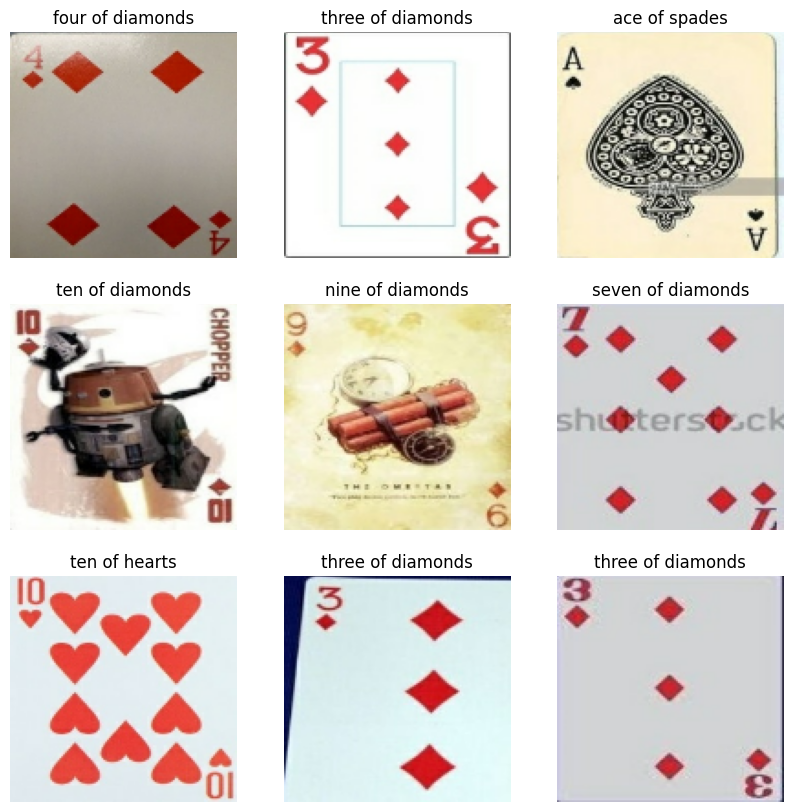

In [131]:
class_names = train_ds.class_names


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [132]:
train_ds
test_ds
valid_ds

num_classes = len(class_names)

## Normalizacja danych

In [133]:
normalization_layer = layers.Rescaling(1./255)

In [134]:
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
valid_ds = valid_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))


In [135]:

for images, labels in train_ds.take(1):
    print(tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())
    break

0.0 1.0


##Model

In [136]:
model = models.Sequential()

In [137]:
num_classes = 53

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(124, 124, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")  # softmax
])




In [138]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 122, 122, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 61, 61, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 59, 59, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 13, 13, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     5,538,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 53)             │        13,621 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,644,917 (21.53 MB)

 Trainable params: 5,644,917 (21.53 MB)

 Non-trainable params: 0 (0.00 B)

In [139]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[
        "accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",       # pilnowanie straty walidacyjnej
    patience=5,
    restore_best_weights=True) # przywróć najlepsze wagi

history = model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[early_stop])

Epoch 1/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.1135 - loss: 3.5886 - val_accuracy: 0.5170 - val_loss: 1.7271
Epoch 2/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4256 - loss: 2.1140 - val_accuracy: 0.7321 - val_loss: 1.0550
Epoch 3/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - accuracy: 0.5902 - loss: 1.5068 - val_accuracy: 0.8000 - val_loss: 0.7773
Epoch 4/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.6706 - loss: 1.1834 - val_accuracy: 0.8075 - val_loss: 0.7575
Epoch 5/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.7407 - loss: 0.9095 - val_accuracy: 0.8377 - val_loss: 0.6349
Epoch 6/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.7913 - loss: 0.7043 - val_accuracy: 0.8038 - val_loss: 0.6489
Epoch 7/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8348 - loss: 0.5863 - val_accuracy: 0.8340 - val_loss: 0.6345
Epoch 8/20
239/239 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - accuracy: 0.8614 - loss: 0.4628 - val_acc

In [140]:
#model.save("cards_cnn_softmax.h5")


## Ewaluacja modelu i wizualizacje

In [141]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8619 - loss: 0.6472
Test accuracy: 0.8264151215553284


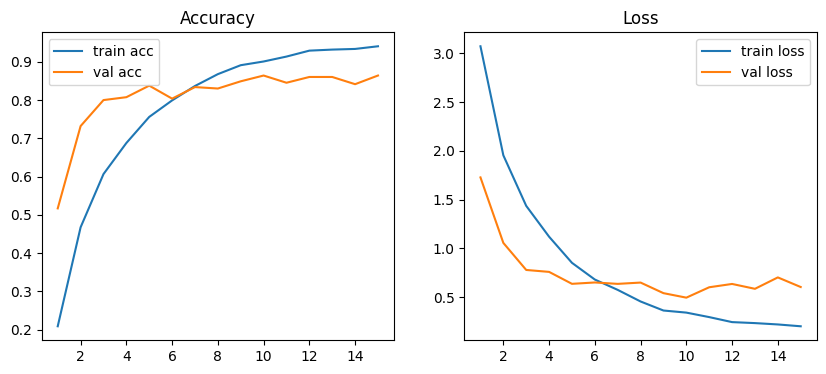

In [142]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label="train acc")
plt.plot(epochs, val_acc, label="val acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, loss, label="train loss")
plt.plot(epochs, val_loss, label="val loss")
plt.legend()
plt.title("Loss")
plt.show()


In [143]:

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, digits=3))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix shape:", cm.shape)


              precision    recall  f1-score   support

           0      0.833     1.000     0.909         5
           1      1.000     1.000     1.000         5
           2      1.000     1.000     1.000         5
           3      1.000     1.000     1.000         5
           4      0.500     1.000     0.667         5
           5      0.714     1.000     0.833         5
           6      0.800     0.800     0.800         5
           7      0.800     0.800     0.800         5
           8      1.000     0.600     0.750         5
           9      0.750     0.600     0.667         5
          10      1.000     0.600     0.750         5
          11      1.000     0.800     0.889         5
          12      1.000     0.800     0.889         5
          13      0.714     1.000     0.833         5
          14      1.000     0.800     0.889         5
          15      0.833     1.000     0.909         5
          16      0.750     0.600     0.667         5
          17      0.800    

makro avg f1 score: 0.824

## Predykcja



In [145]:
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=42,
    image_size=(124, 124),
    batch_size=32,
)

class_names = train_ds_raw.class_names
print(class_names)

# potem dopiero normalizacja itp.
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds_raw.map(lambda x, y: (normalization_layer(x), y))


Found 265 files belonging to 53 classes.
['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


In [146]:

class_names = sorted(os.listdir(data_dir))
print(class_names)


['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hearts', 'three of spades', 'two of clubs', 'two of diamonds', 'two of hearts', 'two of spades']


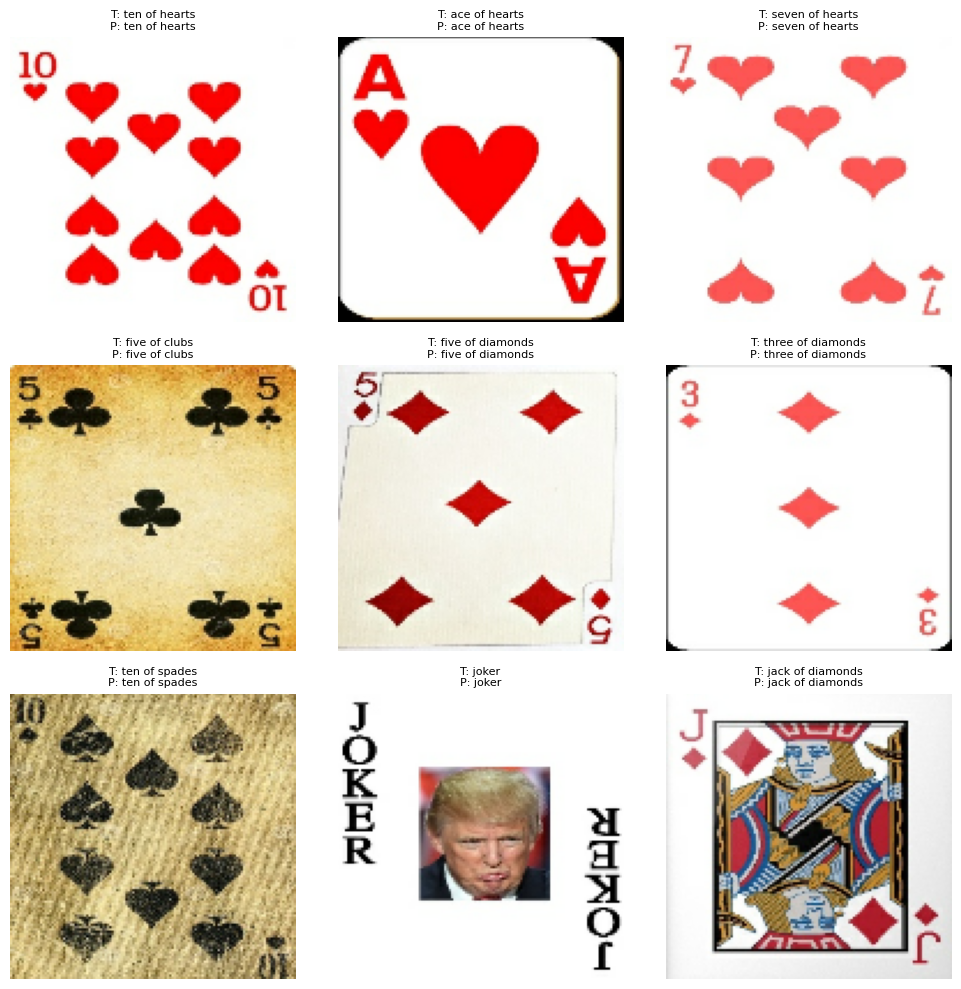

In [147]:
n = 9

images_batch = []
labels_batch = []

for images, labels in test_ds:
    images_batch.extend(images.numpy())
    labels_batch.extend(labels.numpy())
    if len(images_batch) >= n:
        break

images_batch = np.array(images_batch[:n])
labels_batch = np.array(labels_batch[:n])

probs = model.predict(images_batch, verbose=0)
preds = np.argmax(probs, axis=1)

cols = 3
rows = n // cols + int(n % cols != 0)
plt.figure(figsize=(10, 10))

for i in range(n):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(images_batch[i])
    plt.axis("off")
    true_name = class_names[int(labels_batch[i])]
    pred_name = class_names[int(preds[i])]
    plt.title(f"T: {true_name}\nP: {pred_name}", fontsize=8)

plt.tight_layout()
plt.show()
